Epoch 1/100  loss=0.150406
Epoch 2/100  loss=0.011889
Epoch 3/100  loss=0.011702
Epoch 4/100  loss=0.008646
Epoch 5/100  loss=0.005419
Epoch 6/100  loss=0.007326
Epoch 7/100  loss=0.003192
Epoch 8/100  loss=0.003892
Epoch 9/100  loss=0.005678
Epoch 10/100  loss=0.002767
Epoch 11/100  loss=0.003073
Epoch 12/100  loss=0.006796
Epoch 13/100  loss=0.003301
Epoch 14/100  loss=0.004813
Epoch 15/100  loss=0.008316
Epoch 16/100  loss=0.007307
Epoch 17/100  loss=0.005310
Epoch 18/100  loss=0.008053
Epoch 19/100  loss=0.006830
Epoch 20/100  loss=0.002031
Epoch 21/100  loss=0.002469
Epoch 22/100  loss=0.002780
Epoch 23/100  loss=0.001529
Epoch 24/100  loss=0.001889
Epoch 25/100  loss=0.001638
Epoch 26/100  loss=0.001373
Epoch 27/100  loss=0.001031
Epoch 28/100  loss=0.001445
Epoch 29/100  loss=0.002014
Epoch 30/100  loss=0.001041
Epoch 31/100  loss=0.001111
Epoch 32/100  loss=0.001077
Epoch 33/100  loss=0.002656
Epoch 34/100  loss=0.001460
Epoch 35/100  loss=0.001226
Epoch 36/100  loss=0.002540
E

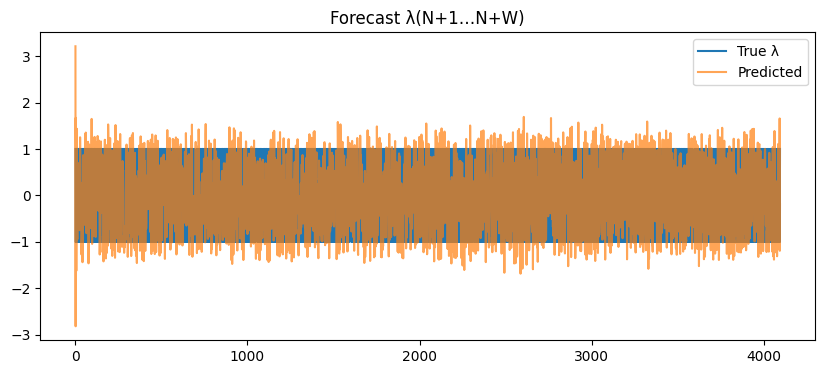

In [ ]:
"""
1. Build Liouville(1…N+W) for N=1e6, window W=4096.
2. Carve Liouville[0…N) into overlapping windows of length W.
3. Convert each window to frequency, apply stable fractional integration.
4. Train a U-Net DDPM to denoise only the “future” half of each spectrum,
   conditioned on the “past” half.
5. Forecast the next window (length W) given the last observed window,
   by clamping its integrated spectrum and diffusing only the unknown bins.
6. Fractionally differentiate & inverse-FFT back to time, yielding λ(N+1…N+W).
7. Compare against true Liouville(N+1…N+W).
"""
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.fft import rfft, irfft, rfftfreq
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# SETTINGS
# -------------------------------------------------------------------------
N_POINTS   = 1_000_000    # length of training series
WINDOW_SZ  = 4096         # forecast window length
STRIDE     = 512          # overlap stride for training windows
GAMMA      = 0.5          # fractional integration order
EPS        = 1e-3         # low-freq stabilization
TIMESTEPS  = 500          # diffusion steps
EPOCHS     = 100          # training epochs
BASE_CH    = 32           # UNet base channels
DEPTH      = 4            # UNet depth
BATCH_SIZE = 8            # windows per batch
DEVICE     = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE      = torch.float32

# -------------------------------------------------------------------------
# 1. Liouville sequence generator
# -------------------------------------------------------------------------
def liouville_sequence(n: int) -> np.ndarray:
    spf   = np.zeros(n+1, dtype=int)
    for p in range(2, n+1):
        if spf[p] == 0:
            spf[p::p] = np.where(spf[p::p] == 0, p, spf[p::p])
    spf[1] = 1
    omega = np.zeros(n+1, dtype=int)
    for k in range(2, n+1):
        omega[k] = omega[k // spf[k]] + 1
    return ((-1) ** omega[1:]).astype(np.float32)

# full array of Liouville up to N+WINDOW_SZ for evaluation
liouville_full = liouville_sequence(N_POINTS + WINDOW_SZ)

# -------------------------------------------------------------------------
# 2. Windowed conditional dataset
# -------------------------------------------------------------------------
class WindowedFreqConditionalDataset(Dataset):
    def __init__(self, series, gamma, eps, window_size, stride, device):
        self.device = device
        self.win    = window_size
        self.stride = stride
        # slice windows from series[0:N_POINTS)
        self.windows = [
            series[i:i+window_size].astype(np.float32)
            for i in range(0, N_POINTS - window_size + 1, stride)
        ]
        # stable fractional‐integration filter
        f      = rfftfreq(window_size, d=1.0)
        H_int  = ((1j*2*np.pi*f)**2 + eps**2)**(-gamma/2)
        self.Hr = torch.from_numpy(H_int.real).to(device, DTYPE)
        self.Hi = torch.from_numpy(H_int.imag).to(device, DTYPE)
        # mask: single channel, first half known (1), second half unknown (0)
        Nf      = window_size//2 + 1
        mask_np = np.zeros((1, Nf), dtype=np.float32)
        mask_np[0, :Nf//2] = 1.0
        self.mask = torch.from_numpy(mask_np).to(device, DTYPE)  # (1, Nf)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        x_win = self.windows[idx]               # (WINDOW_SZ,)
        Xc    = rfft(x_win)                     # (Nf,)
        Xr    = torch.from_numpy(Xc.real).to(self.device, DTYPE)
        Xi    = torch.from_numpy(Xc.imag).to(self.device, DTYPE)
        # fractionally integrate
        Yr    = Xr * self.Hr - Xi * self.Hi
        Yi    = Xr * self.Hi + Xi * self.Hr
        X_int = torch.stack([Yr, Yi], dim=0)    # (2, Nf)
        X_obs = X_int * self.mask               # (2, Nf), broadcasting mask
        return X_int, X_obs, self.mask         # shapes: (2,Nf), (2,Nf), (1,Nf)

dataset = WindowedFreqConditionalDataset(
    series=liouville_full,
    gamma=GAMMA, eps=EPS,
    window_size=WINDOW_SZ,
    stride=STRIDE,
    device=DEVICE
)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0   # avoid CUDA-in-fork errors
)

# -------------------------------------------------------------------------
# 3. Precompute fractional‐differentiation filter for forecast step
# -------------------------------------------------------------------------
f_win   = rfftfreq(WINDOW_SZ, d=1.0)
H_diff  = ((1j*2*np.pi*f_win)**2 + EPS**2)**( GAMMA/2)
Hdiff_r = torch.from_numpy(H_diff.real).to(DEVICE, DTYPE)
Hdiff_i = torch.from_numpy(H_diff.imag).to(DEVICE, DTYPE)

# -------------------------------------------------------------------------
# 4. UNet-1D (5-channel input: noisy(2), obs(2), mask(1))
# -------------------------------------------------------------------------
def conv_block(ch_in, ch_out):
    return nn.Sequential(
        nn.Conv1d(ch_in,  ch_out, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv1d(ch_out, ch_out, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet1D(nn.Module):
    def __init__(self, in_ch=5, base_ch=BASE_CH, depth=DEPTH):
        super().__init__()
        self.downs = nn.ModuleList()
        ch = in_ch
        for d in range(depth):
            ch_out = base_ch * (2**d)
            self.downs.append(nn.ModuleDict({
                'conv': conv_block(ch,   ch_out),
                'down': nn.Conv1d(ch_out, ch_out, 3, stride=2, padding=1)
            }))
            ch = ch_out
        self.bottleneck = conv_block(ch, ch*2)
        ch *= 2
        self.ups = nn.ModuleList()
        for d in reversed(range(depth)):
            ch_out = base_ch * (2**d)
            self.ups.append(nn.ModuleDict({
                'conv': conv_block(ch + ch_out, ch_out)
            }))
            ch = ch_out
        self.final = nn.Conv1d(ch, 2, 1)  # predict noise in 2 channels

    def forward(self, x):
        skips = []
        for layer in self.downs:
            x = layer['conv'](x); skips.append(x)
            x = layer['down'](x)
        x = self.bottleneck(x)
        for layer in self.ups:
            skip = skips.pop()
            x    = F.interpolate(x, size=skip.shape[-1], mode='linear', align_corners=False)
            x    = torch.cat([x, skip], dim=1)
            x    = layer['conv'](x)
        return self.final(x)

# -------------------------------------------------------------------------
# 5. Conditional DDPM in frequency domain
# -------------------------------------------------------------------------
class ConditionalDiffusion1D:
    def __init__(self, model, T, device):
        self.model     = model.to(device)
        betas          = torch.linspace(1e-4, 2e-2, T, device=device, dtype=DTYPE)
        self.alpha     = 1 - betas
        self.alpha_cum = torch.cumprod(self.alpha, dim=0)
        self.T         = T
        self.device    = device

    def q_sample(self, x0, t, noise):
        a = self.alpha_cum[t].sqrt().view(-1,1,1)
        b = (1 - self.alpha_cum[t]).sqrt().view(-1,1,1)
        return a * x0 + b * noise

    def p_losses(self, X_int, X_obs, mask, t):
        noise = torch.randn_like(X_int)
        x0    = X_obs * mask + noise * (1 - mask)
        x_t   = self.q_sample(x0, t, noise)
        inp   = torch.cat([x_t, X_obs, mask], dim=1)  # (B,5,Nf)
        pred  = self.model(inp)                       # (B,2,Nf)
        return F.mse_loss(pred * (1-mask), noise * (1-mask))

    def train(self, loader, epochs, lr=1e-4):
        opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.model.train()
        for ep in range(1, epochs+1):
            for X_int, X_obs, mask in loader:
                X_int, X_obs, mask = [t.to(self.device) for t in (X_int, X_obs, mask)]
                B = X_int.size(0)
                t = torch.randint(0, self.T, (B,), device=self.device)
                loss = self.p_losses(X_int, X_obs, mask, t)
                opt.zero_grad(); loss.backward(); opt.step()
            print(f"Epoch {ep}/{epochs}  loss={loss.item():.6f}")

    @torch.no_grad()
    def sample(self, X_obs, mask):
        x = X_obs * mask + torch.randn_like(X_obs) * (1 - mask)
        for i in reversed(range(self.T)):
            t   = torch.full((1,), i, device=self.device, dtype=torch.long)
            inp = torch.cat([x, X_obs, mask], dim=1)
            eps = self.model(inp)
            b   = 1 - self.alpha[i]
            a   = self.alpha[i]
            ac  = self.alpha_cum[i]
            coef= b / (1 - ac).sqrt()
            x   = (x - coef * eps) / a.sqrt()
            x   = X_obs * mask + x * (1 - mask)
            if i > 0:
                x = x + (1 - mask) * b.sqrt() * torch.randn_like(x)
        return x  # (1,2,Nf)

# -------------------------------------------------------------------------
# 6. Train conditional model
# -------------------------------------------------------------------------
unet      = UNet1D(in_ch=5, base_ch=BASE_CH, depth=DEPTH)
cond_diff = ConditionalDiffusion1D(unet, TIMESTEPS, DEVICE)
cond_diff.train(loader, EPOCHS)

# -------------------------------------------------------------------------
# 7. Forecast next window λ(N+1…N+W)
# -------------------------------------------------------------------------
# last observed window
last_win = liouville_full[N_POINTS-WINDOW_SZ:N_POINTS]
Xc       = rfft(last_win)
Xr       = torch.from_numpy(Xc.real).to(DEVICE,DTYPE)
Xi       = torch.from_numpy(Xc.imag).to(DEVICE,DTYPE)
Yr       = Xr * dataset.Hr - Xi * dataset.Hi
Yi       = Xr * dataset.Hi + Xi * dataset.Hr
X_obs    = torch.stack([Yr, Yi], dim=0).unsqueeze(0)  # (1,2,Nf)
mask_win = dataset.mask.unsqueeze(0)                 # (1,1,Nf)

X_int_pred = cond_diff.sample(X_obs, mask_win)       # (1,2,Nf)
R_pred, I_pred = X_int_pred[0]
Xr_p = R_pred * Hdiff_r - I_pred * Hdiff_i
Xi_p = R_pred * Hdiff_i + I_pred * Hdiff_r
spec_pred = Xr_p.cpu().numpy() + 1j * Xi_p.cpu().numpy()
y_pred = irfft(spec_pred, n=WINDOW_SZ)               # (WINDOW_SZ,)

# -------------------------------------------------------------------------
# 8. Evaluate forecast
# -------------------------------------------------------------------------
true_next = liouville_full[N_POINTS:N_POINTS+WINDOW_SZ]
pred_sign = np.sign(y_pred); pred_sign[pred_sign==0] = 1

accuracy = (pred_sign == true_next).mean()
mse_val  = ((y_pred - true_next)**2).mean()
tp = np.sum((pred_sign== 1)&(true_next== 1))
tn = np.sum((pred_sign==-1)&(true_next==-1))
fp = np.sum((pred_sign== 1)&(true_next==-1))
fn = np.sum((pred_sign==-1)&(true_next== 1))

print(f"Forecast Accuracy: {accuracy*100:.2f}%  MSE: {mse_val:.6f}")
print("TP, TN, FP, FN =", tp, tn, fp, fn)

plt.figure(figsize=(10,4))
plt.plot(true_next, label='True λ')
plt.plot(y_pred,    label='Predicted', alpha=0.7)
plt.title('Forecast λ(N+1…N+W)'); plt.legend(); plt.show()

In [ ]:
# Directional accuracy: predicting up/down relative to the last known observation
import numpy as np

# last observed value at time N
last_obs = liouville_full[N_POINTS-1]

# true and predicted directions relative to last_obs
dir_true_rel = np.sign(true_next - last_obs)
dir_pred_rel = np.sign(y_pred    - last_obs)
# map zeros (no change) to +1 (arbitrary)
dir_true_rel[dir_true_rel == 0] = 1
dir_pred_rel[dir_pred_rel == 0] = 1
dir_acc_rel = (dir_pred_rel == dir_true_rel).mean()
print(f"Directional accuracy (relative to last obs): {dir_acc_rel*100:.2f}%")

# Directional accuracy: predicting up/down between successive points in the forecast window
dir_true_seq = np.sign(true_next[1:] - true_next[:-1])
dir_pred_seq = np.sign(y_pred[1:]      - y_pred[:-1])
dir_true_seq[dir_true_seq == 0] = 1
dir_pred_seq[dir_pred_seq == 0] = 1
dir_acc_seq = (dir_pred_seq == dir_true_seq).mean()
print(f"Directional accuracy (successive in window): {dir_acc_seq*100:.2f}%")

Directional accuracy (relative to last obs): 50.32%
Directional accuracy (successive in window): 49.91%


Directional accuracy (relative to last obs): 50.32%
Directional accuracy (successive in window) : 49.91%


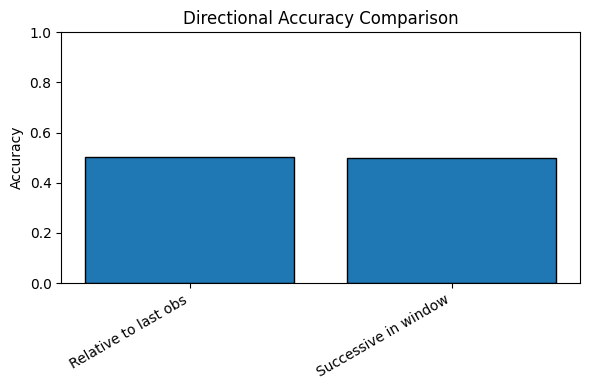

In [ ]:
# Directional accuracy and bar plot
import numpy as np
import matplotlib.pyplot as plt

# last observed value at time N
last_obs = liouville_full[N_POINTS-1]

# 1) Directional accuracy relative to last observation
dir_true_rel = np.sign(true_next - last_obs)
dir_pred_rel = np.sign(y_pred    - last_obs)
dir_true_rel[dir_true_rel == 0] = 1
dir_pred_rel[dir_pred_rel == 0] = 1
dir_acc_rel  = (dir_pred_rel == dir_true_rel).mean()

# 2) Directional accuracy between successive points in the forecast window
dir_true_seq = np.sign(true_next[1:] - true_next[:-1])
dir_pred_seq = np.sign(y_pred[1:]      - y_pred[:-1])
dir_true_seq[dir_true_seq == 0] = 1
dir_pred_seq[dir_pred_seq == 0] = 1
dir_acc_seq  = (dir_pred_seq == dir_true_seq).mean()

print(f"Directional accuracy (relative to last obs): {dir_acc_rel*100:.2f}%")
print(f"Directional accuracy (successive in window) : {dir_acc_seq*100:.2f}%")

# Bar plot of the two directional accuracies
labels = ['Relative to last obs', 'Successive in window']
accuracies = [dir_acc_rel, dir_acc_seq]

plt.figure(figsize=(6,4))
plt.bar(labels, accuracies, edgecolor='k')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Directional Accuracy Comparison')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()